# AA Run
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 8/4/2021|
|Updated | 8/6/2021|

## Introduction

### Parameters

| AC Run                                                                                                ||| $\tau_\textrm{s}$ | $\epsilon$ | $L_x \times L_y \times L_z$           | $N_x \times N_y \times N_z$ | $N_\textrm{p}$   | $n_\textrm{p}$ | $t_\textrm{sim}$      |
|-------------------------------------------------------------------------------------------------------|||-------------------|------------|---------------------------------------|-----------------------------|------------------|----------------|-----------------------|
| [**JY07**](https://doi.org/10.1086/516730) **Units**                                                  ||| $0.1$             | $0.2$      | $4.0 \times 4.0 \times 4.0\,[\eta r]$ | $256 \times 1 \times 256$   | $...$            | $...$          | $2000.0\,\Omega^{-1}$ |
| [**Code Units**](https://github.com/sabaronett/streaming-instability/blob/main/ipynb/CodeUnits.ipynb) ||| $1/(20\pi)$       | $0.2$      | $0.2 \times 0.2 \times 0.2\,[H]$      | $256 \times 1 \times 256$   | $2.6\times 10^5$ | $4$            | $400\,T$              |

**NOTE**—JY07 used a two-fluid approach for this AA run due to computational cost at the time (see §3.3.2, p. 633).

### Performance

| Compute Node | Microarchitecture | Cores/Node | PBS Code | CPU Time (m) | zone-cycles /cpu_second |
|--------------|-------------------|------------|----------|--------------|-------------------------|
| Pleiades     | Broadwell         | 28         | bro      | 519          | 1.70e+07                |

**NOTE**—Since this run was restarted at ~$t = 3.57\,T$, we simply summed `cpu time used`, and took the weighted average of `zone-cycles/cpu_second` (with respect to elapsed simulation time for each sub-run), across both console outputs.

### Preliminary

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Get input parameters
athinput = athena_read.athinput('athinput.si')
tlim = athinput['time']['tlim']              # time limit / T
c_s = athinput['hydro']['iso_sound_speed']   # sound speed
Np_tot = athinput['problem']['npx1']\
         *athinput['problem']['npx2']\
         *athinput['problem']['npx3']        # total number of particles
Omega = athinput['problem']['omega']         # local Keplerian ang. freq.
epsilon = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
Pi = athinput['problem']['duy0']             # global rad. press. grad.
tau_s = athinput['particles']['taus0']*Omega # dimensionless stopping time
T = 2*np.pi/Omega                            # orbital period
etav_K = Pi*c_s                              # velocity (JY07)

# Collect HDF5 outputs
outputs = sorted(list(Path('../athdf').glob(athinput['job']['problem_id'] +
                                            '.out2.*.athdf')))

# Get history output
hst = athena_read.hst('SI.hst')

## Particle Density Animation

In [7]:
IFrame('https://www.youtube.com/embed/EqM18P5MiFA', 560, 315)

## Maximum Particle Density Evolution

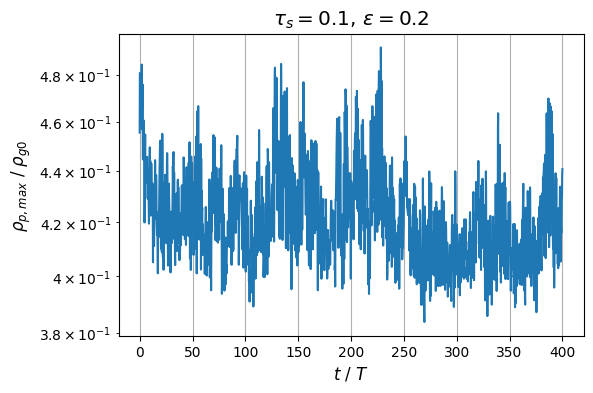

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Load NAS results
data = np.loadtxt('plots/growth.txt')
times = data[:, 0]
rhopmax = data[:, 1]

# Plot
fig, ax = plt.subplots(dpi=100)
ax.set_title(r'$\tau_s={:.1f},\,\epsilon={:.1f}$'
             .format(tau_s, epsilon), size='x-large')
ax.set_ylabel(r'$\rho_{p,max}$ / $\rho_{g0}$', size='large')
ax.set_xlabel(r'$t$ / $T$', size='large')
# ax.set_ylim(0.15, 0.35)
ax.semilogy(times, rhopmax)
ax.grid()

**NOTE**: We define $t_\textrm{sat} = 25\,T$ in the calculations and plots below.

In [4]:
t_sat = 25 # T

## Cumulative Particle Density Distribution

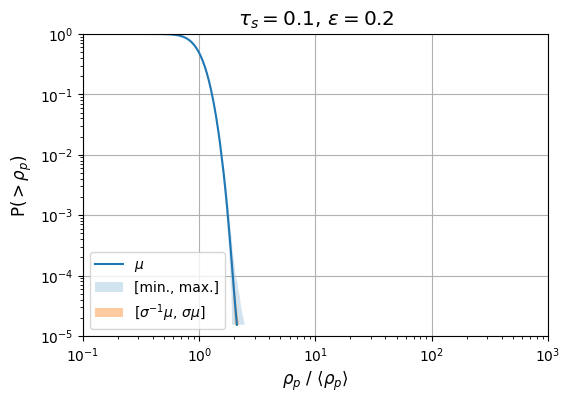

In [5]:
# Load NAS results
data = np.loadtxt('plots/cpdd_min.txt')
cdf = data[:, 1]
min_rhops = data[:, 0]
data = np.loadtxt('plots/cpdd_max.txt')
max_rhops = data[:, 0]
data = np.loadtxt('plots/cpdd_avg.txt')
avg_rhops = data[:, 0]
data = np.loadtxt('plots/cpdd_std.txt')
std_rhops = data[:, 0]

# CPDD
fig, ax = plt.subplots(dpi=100)
ax.set_title(r'$\tau_s={:.1f},\,\epsilon={:.1f}$'
             .format(tau_s, epsilon), size='x-large')
ax.set_xlabel(r'$\rho_p$ / $\langle \rho_p \rangle$', size='large')
ax.set_ylabel(r'P$(>\rho_p)$', size='large')
ax.loglog(avg_rhops, cdf, label=r'$\mu$')
ax.fill_betweenx(cdf, min_rhops, max_rhops, alpha=0.2, label='[min., max.]')
ax.fill_betweenx(cdf, avg_rhops/std_rhops, avg_rhops*std_rhops, alpha=0.4,
                 label=r'$[\sigma^{-1}\mu,\,\sigma\mu]$')
ax.set_xlim(0.1, 1000)
ax.set_ylim(1e-5, 1)
ax.legend(loc='lower left')
ax.grid()

**NOTE**:
- We compute the statistical values over the time-varying saturated state defined [above](#Maximum-Particle-Density-Evolution).
- We calculate the standard deviation, $\sigma$, in logarithmic space.

## Velocity Dispersion

In [6]:
# Time-averaged velocities over saturated state
ref_vx = -0.138                      # [𝜂𝑣ₖ] (JY07, Table 2)
i_sat = hst['time'].size*t_sat//tlim # saturation output start
avg_vp1s = np.average(hst['vp1'][i_sat:])/etav_K/Np_tot
avg_vp2s = np.average(hst['vp2'][i_sat:])/etav_K/Np_tot
avg_vp3s = np.average(hst['vp3'][i_sat:])/etav_K/Np_tot
ref_diff = 100*2*np.abs((avg_vp1s - ref_vx) / (avg_vp1s + ref_vx))

df = pd.DataFrame(
    {
        "Run": ["AA"],
        r"$\overline{v_x}$": [avg_vp1s],
        "% diff (JY07)": [ref_diff],
        r"$\overline{v_y}$": [avg_vp3s],
        r"$\overline{v_z}$": [avg_vp2s],
    }
)
df.style.format({
    r"$\overline{v_x}$": "{:.3f}",
    "% diff (JY07)": "{:.1f}",
    r"$\overline{v_y}$": "{:.3f}",
    r"$\overline{v_z}$": "{:.3f}",
})

,Run,$\overline{v_x}$,% diff (JY07),$\overline{v_y}$,$\overline{v_z}$
0,AA,-0.138,0.0,-0.828,0.000


## Tasks

- [x] Configure `athinput.si` with converted JY07 run [parameters](#Parameters)
- [x] Run simulation: `qsub run.pbs`
- [x] Run `growth.py`
- [x] Transfer from NAS, `sup shiftc -r [source] [target]`:
  - [x] Console output
  - [x] `SI.hst`
  - [x] `plots/`
- [x] Record performance: (1) CPU Time (m); (2) zone-cycles /cpu_second
- [x] `cpdd.py`:
  - [x] Set `i_sat` from `growth.pdf` then run; 
  - [x] Re-transfer `plots/`
- [x] Compute velocity dispersions with defined `i_sat`
- [x] Particle density animation:
  - [x] `mov.py`: Set `vmin` and `vmax` from `growth.pdf` then run
  - [x] Transfer `rhop.mp4` from NAS
  - [x] Upload to YouTube
  - [x] Embed in [Particle Density Animation](#Particle-Density-Animation)